# Global SuperStore Data



*   The Global Super Store data set is a customer centric dataset, which has the data of all the orders that have been place through different vendors and markets.​

*   The dataset set has around 50000 rows and 24 columns.​



## Importing the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

# machine learning
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

## Loading the SuperStore data

In [2]:
# Laoding the data into a dataframe.
super_store_data = pd.read_excel("Data/Global_superstore_2016.xlsx")

In [3]:
super_store_data.shape

(51290, 24)

In [4]:
super_store_data.info() 
# info() gives us the number of non null values and the data type of each column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   Postal Code     9994 non-null   float64       
 9   City            51290 non-null  object        
 10  State           51290 non-null  object        
 11  Country         51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Market          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

Dropping the Customer Name column, as it contains personally identifiable information.

In [5]:
super_store_data = super_store_data.drop("Customer Name",axis=1)
# Looking at the top 5 rows of the dataframe.
super_store_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Postal Code,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Consumer,73120.0,Oklahoma City,Oklahoma,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544,40.77,High
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Corporate,NaN,Wollongong,New South Wales,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Consumer,NaN,Brisbane,Queensland,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Home Office,NaN,Berlin,Berlin,...,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Consumer,NaN,Dakar,Dakar,...,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


## Exploratory Data Analysis

Verifying if the data contains null values:

In [6]:
super_store_data.isnull().sum()

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Segment               0
Postal Code       41296
City                  0
State                 0
Country               0
Region                0
Market                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

As postal code doesn't play a key role for CLV analysis, we are ignoring the missing postal codes.

Performing statistical analysis on the applicable features:

In [7]:
# looking at the min, max, mean, standard deviation and quartile values of the numerical values.
super_store_data[["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]].describe()

,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,246.490581,3.476545,0.142908,28.610982,26.478567
std,487.565361,2.278766,0.212280,174.340972,57.251373
min,0.444000,1.000000,0.000000,-6599.978000,1.002000
25%,30.758625,2.000000,0.000000,0.000000,2.610000
50%,85.053000,3.000000,0.000000,9.240000,7.790000
75%,251.053200,5.000000,0.200000,36.810000,24.450000
max,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [8]:
# First Transaction Date
super_store_data["Order Date"].min()

Timestamp('2012-01-01 00:00:00')

In [9]:
# Last Transaction Date
super_store_data["Order Date"].max()

Timestamp('2015-12-31 00:00:00')

In [10]:
# NUmber of Unique Customers
super_store_data["Customer ID"].nunique()

17415

In [11]:
# Total Revenue.
super_store_data["Sales"].sum()

12642501.90988

In [12]:
#Mean Sales value per transaction
super_store_data["Sales"].mean()

246.4905812025821

In [13]:
super_store_data["Sales"].median()

85.053

In [14]:
order_count = pd.DataFrame((super_store_data.groupby("Customer ID")["Order Date"].count()).sort_values(ascending=False))


In [15]:
order_count[order_count["Order Date"]>1].shape

(11350, 1)

In [16]:
#Average of mean sales per customer
super_store_data.groupby("Customer ID")["Sales"].mean().mean()

241.38291683146747

Analysing the Profit feature, as above noticed transactions with negative profit

In [17]:
super_store_data[super_store_data["Profit"]<0].transpose()

,1,3,16,30,40,65,73,76,83,85,...,51246,51252,51256,51257,51259,51260,51266,51275,51277,51279
Row ID,26341,13524,39519,220,21316,32637,21209,33130,40425,23013,...,31887,40220,29192,35397,36230,35398,27081,46231,46582,43818
Order ID,IN-2014-JR162107-41675,ES-2014-KM1637548-41667,CA-2012-AB10015140-40958,US-2012-RR1952536-41270,ID-2014-JB1600059-41873,CA-2015-AS10045140-42007,IN-2015-LA1678059-42242,CA-2015-AS10045140-42218,US-2015-AS10045140-42252,ID-2013-AM1070559-41535,...,US-2014-ZC21910140-41719,CA-2015-ZC21910140-42167,ID-2015-JE1561097-42193,US-2015-ZC21910140-42175,CA-2013-ZC21910140-41545,US-2015-ZC21910140-42175,ID-2013-EK13795102-41496,ZA-2012-AS285147-40988,TU-2015-KF6285134-42337,NI-2012-PO886595-41159
Order Date,2014-02-05 00:00:00,2014-01-28 00:00:00,2012-02-19 00:00:00,2012-12-27 00:00:00,2014-08-22 00:00:00,2015-01-03 00:00:00,2015-08-26 00:00:00,2015-08-02 00:00:00,2015-09-05 00:00:00,2013-09-18 00:00:00,...,2014-03-21 00:00:00,2015-06-12 00:00:00,2015-07-08 00:00:00,2015-06-20 00:00:00,2013-09-28 00:00:00,2015-06-20 00:00:00,2013-08-10 00:00:00,2012-03-20 00:00:00,2015-11-29 00:00:00,2012-09-07 00:00:00
Ship Date,2014-02-07 00:00:00,2014-01-30 00:00:00,2012-02-25 00:00:00,2012-12-29 00:00:00,2014-08-26 00:00:00,2015-01-05 00:00:00,2015-08-27 00:00:00,2015-08-08 00:00:00,2015-09-06 00:00:00,2013-09-21 00:00:00,...,2014-03-25 00:00:00,2015-06-18 00:00:00,2015-07-13 00:00:00,2015-06-24 00:00:00,2013-10-04 00:00:00,2015-06-24 00:00:00,2013-08-11 00:00:00,2012-03-25 00:00:00,2015-11-30 00:00:00,2012-09-09 00:00:00
Ship Mode,Second Class,First Class,Standard Class,Second Class,Standard Class,First Class,First Class,Standard Class,First Class,Second Class,...,Standard Class,Standard Class,Standard Class,Standard Class,Standard Class,Standard Class,First Class,Standard Class,First Class,Second Class
Customer ID,JR-162107,KM-1637548,AB-100151402,RR-1952536,JB-1600059,AS-100451408,LA-1678059,AS-100451402,AS-100451404,AM-1070559,...,ZC-219101404,ZC-219101408,JE-1561097,ZC-219101402,ZC-219101404,ZC-219101402,EK-13795102,AS-285147,KF-6285134,PO-886595
Segment,Corporate,Home Office,Consumer,Corporate,Consumer,Corporate,Corporate,Corporate,Corporate,Consumer,...,Consumer,Consumer,Corporate,Consumer,Consumer,Consumer,Home Office,Corporate,Home Office,Consumer
Postal Code,NaN,NaN,76017.0,NaN,NaN,28540.0,NaN,78745.0,97756.0,NaN,...,97301.0,28601.0,NaN,77095.0,80013.0,77095.0,NaN,NaN,NaN,NaN
City,Wollongong,Berlin,Arlington,Santo Domingo,Mataram,Jacksonville,Palembang,Austin,Redmond,Bandung,...,Salem,Hickory,Lahore,Houston,Aurora,Houston,Pasig,Harare,Midyat,Lagos
State,New South Wales,Berlin,Texas,Santo Domingo,Nusa Tenggara Barat,North Carolina,Sumatera Selatan,Texas,Oregon,Jawa Barat,...,Oregon,North Carolina,Punjab,Texas,Colorado,Texas,National Capital,Harare,Mardin,Lagos


Observed that there are 12544 transations with negative profit. As not every transaction is profitable, considering the negative profit transactions as correct data

In [18]:
print("Count of orders per customer:")
pd.DataFrame(super_store_data["Customer ID"].value_counts())

Count of orders per customer:


,Customer ID
SV-203651406,26
WB-218501404,24
AP-109151404,23
EM-1396082,21
CS-121757,20
...,...
LW-7125137,1
EM-1420011,1
RB-193601402,1
NC-1862558,1


In [19]:
print("Total unique customers:")
super_store_data["Customer ID"].nunique()

Total unique customers:


17415

### How many orders are placed by most customers?

In [20]:
super_store_data["Customer ID"].value_counts()

SV-203651406    26
WB-218501404    24
AP-109151404    23
EM-1396082      21
CS-121757       20
                ..
LW-7125137       1
EM-1420011       1
RB-193601402     1
NC-1862558       1
JK-5205110       1
Name: Customer ID, Length: 17415, dtype: int64

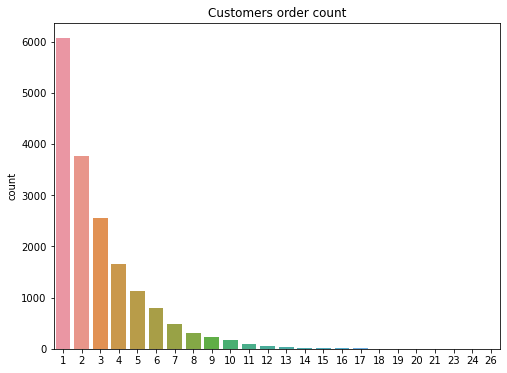

In [21]:
plt.figure(figsize=(8,6))
sns.countplot(x=super_store_data["Customer ID"].value_counts().values)
plt.title("Customers order count")
plt.show()

From the above visual, I conclude that majority of the customers placed 1- 2 orders during the period of study

### How has the order count been over the time period?

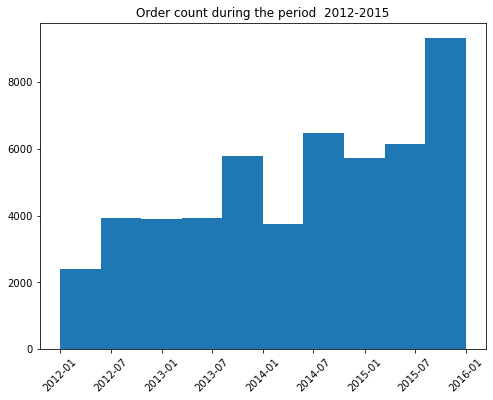

In [22]:
plt.figure(figsize=(8,6))
plt.hist(super_store_data["Order Date"])
plt.title("Order count during the period  2012-2015")
plt.xticks(rotation=45)
plt.show()

Noticed that the orders count increased as the time progressed

### What's the customer segment that's placing most orders?

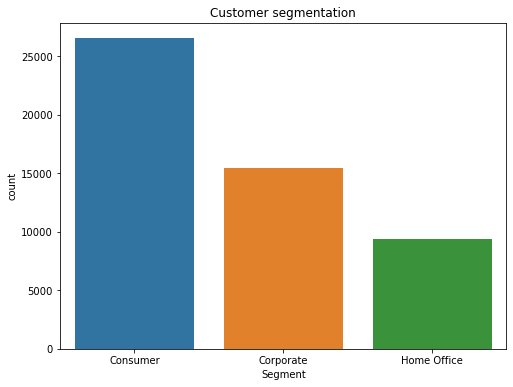

In [23]:
plt.figure(figsize=(8,6))
sns.countplot(data=super_store_data, x= "Segment")
plt.title("Customer segmentation")
plt.show()

Consumers segment is placing the most orders followed by corporate

In [24]:
super_store_data["City"].value_counts()

New York City    915
Los Angeles      747
Philadelphia     537
San Francisco    510
Santo Domingo    443
                ... 
Vacaville          1
Yuanjiang          1
Abreu e Lima       1
Annemasse          1
Krasnyy Luch       1
Name: City, Length: 3650, dtype: int64

In [25]:
print("Orders have been shipped to {} cities".format(super_store_data["City"].nunique()))

Orders have been shipped to 3650 cities


In [26]:
super_store_data["Country"].value_counts()

United States    9994
Australia        2837
France           2827
Mexico           2635
Germany          2063
                 ... 
Malawi              1
Bhutan              1
Suriname            1
Kuwait              1
The Gambia          1
Name: Country, Length: 165, dtype: int64

In [27]:
print("Orders have been shipped to {} countries".format(super_store_data["Country"].nunique()))

Orders have been shipped to 165 countries


### What's the customer base in each region?

In [28]:
super_store_data["Region"].value_counts()

Western Europe       5883
Central America      5616
Oceania              3487
Western US           3203
Southeastern Asia    3129
South America        2988
Eastern US           2848
Southern Asia        2655
Western Asia         2440
Eastern Asia         2374
Central US           2323
Northern Europe      2204
Southern Europe      2113
Caribbean            1690
Southern US          1620
Eastern Europe       1529
Western Africa       1460
North Africa         1278
Eastern Africa        728
Central Africa        643
Southern Africa       478
Canada                384
Central Asia          217
Name: Region, dtype: int64

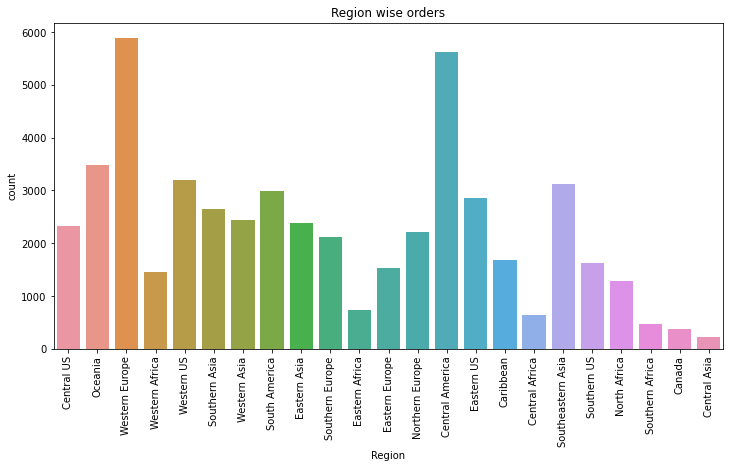

In [29]:
plt.figure(figsize=(12,6))
sns.countplot(data=super_store_data, x= "Region")
plt.title("Region wise orders")
plt.xticks(rotation=90)
plt.show()

### What's the orders share from each region?

In [30]:
super_store_data["Market"].value_counts()

Asia Pacific    14302
Europe          11729
USCA            10378
LATAM           10294
Africa           4587
Name: Market, dtype: int64

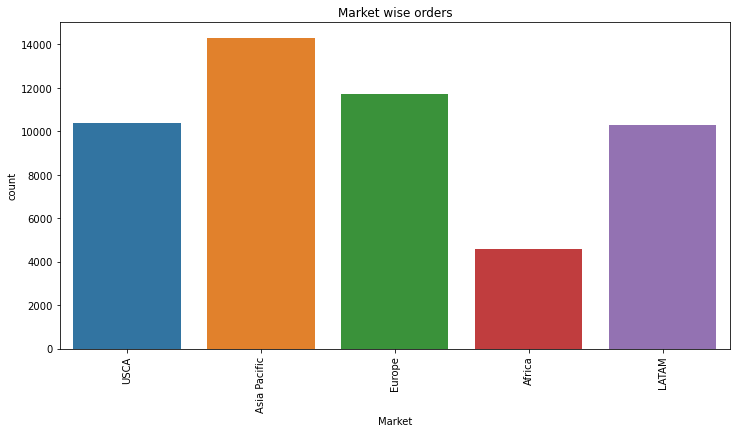

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(data=super_store_data, x= "Market")
plt.title("Market wise orders")
plt.xticks(rotation=90)
plt.show()

### What category of products are most sold?

In [32]:
super_store_data["Category"].value_counts()

Office Supplies    31289
Technology         10141
Furniture           9860
Name: Category, dtype: int64

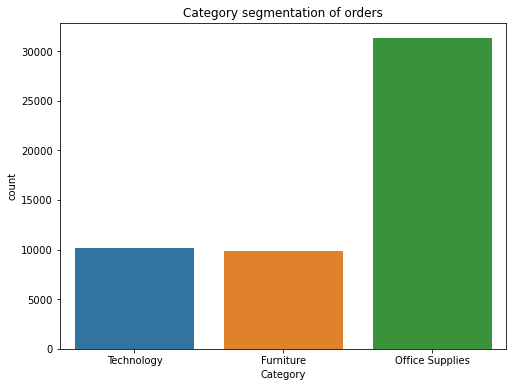

In [33]:
plt.figure(figsize=(8,6))
sns.countplot(data=super_store_data,x="Category")
plt.title("Category segmentation of orders")
plt.show()

From the above visual, it is clear that the Global superstore dataset consists of maily office supplies related orders during the period of study

In [34]:
super_store_data["Sub-Category"].value_counts()

Binders        6146
Storage        5049
Art            4864
Paper          3492
Chairs         3434
Phones         3357
Furnishings    3154
Accessories    3075
Fasteners      2601
Labels         2601
Bookcases      2411
Supplies       2407
Envelopes      2387
Copiers        2223
Appliances     1742
Machines       1486
Tables          861
Name: Sub-Category, dtype: int64

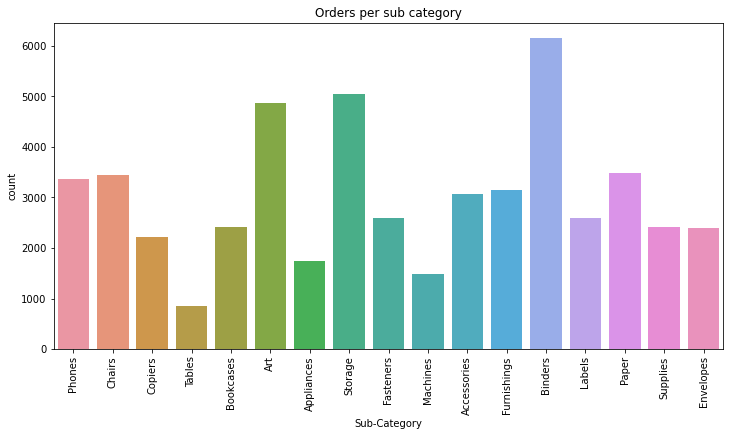

In [35]:
plt.figure(figsize=(12,6))
sns.countplot(data=super_store_data, x="Sub-Category")
plt.xticks(rotation=90)
plt.title("Orders per sub category")
plt.show()

### Customers generating the most sales?

In [36]:
super_store_data.groupby("Customer ID")["Sales"].sum().sort_values(ascending=False)

Customer ID
SM-203201408    23669.196
TC-209801402    18437.138
RB-193601404    14345.276
TA-213851406    13723.498
AB-101051402    12181.594
                  ...    
CC-123701402        1.248
KN-164501408        1.167
TS-213401402        1.112
JO-152801406        0.852
RS-197651402        0.556
Name: Sales, Length: 17415, dtype: float64

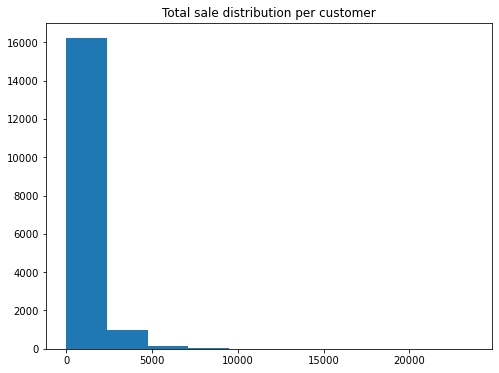

In [37]:
plt.figure(figsize=(8,6))
plt.hist(super_store_data.groupby("Customer ID")["Sales"].sum().values)
plt.title("Total sale distribution per customer")
plt.show()

### Customers placing the most orders?

In [38]:
super_store_data.groupby("Customer ID")["Order ID"].count().sort_values(ascending=False)

Customer ID
SV-203651406    26
WB-218501404    24
AP-109151404    23
EM-1396082      21
CS-121757       20
                ..
NG-835595        1
EJ-137201406     1
EJ-1372039       1
EJ-1372045       1
DK-1309051       1
Name: Order ID, Length: 17415, dtype: int64

## Cohort Analysis

In [39]:
# Customers first transaction. Considering the first transaction of the customers as a subset to perfrom our analysis.
GD_FIRST_TRANSACTION = super_store_data.sort_values(["Customer ID", "Order Date"]) \
                               .groupby("Customer ID").first()
GD_FIRST_TRANSACTION.shape

(17415, 22)

In [40]:
# first new customer.
GD_FIRST_TRANSACTION["Order Date"].min()

Timestamp('2012-01-01 00:00:00')

In [41]:
# last new customer
GD_FIRST_TRANSACTION["Order Date"].max()

Timestamp('2015-12-31 00:00:00')

In [42]:
# GETTING THE UNIQUE CUSTOMERS ID's
IDs = super_store_data['Customer ID'].unique()
IDs_SAMPLE = IDs[0:10]

In [43]:
# Creating a subset of the dataset with ten unique customer IDs
GD_SUBSET = super_store_data[super_store_data['Customer ID'].isin(IDs_SAMPLE)].groupby(['Customer ID', 'Order Date']).sum().reset_index()
GD_SUBSET.head()

,Customer ID,Order Date,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
0,AB-100151402,2012-02-19,39519,76017.0,12.624,2,0.2,-2.5248,1.97
1,AB-100151402,2014-11-11,80197,146240.0,563.940,4,0.0,116.8680,66.04
2,AB-100151404,2012-03-06,108777,294309.0,309.592,7,0.2,15.0033,16.70
3,AJ-107801,2013-04-19,28879,0.0,4626.150,5,0.0,647.5500,835.57
4,CR-127307,2014-05-01,63942,0.0,292.167,12,0.3,58.5870,30.69


In [44]:
pip install plydata

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pytz>=2017.3 in c:\users\nabhi\anaconda3\lib\site-packages (from pandas>=1.1.5->plydata) (2021.1)



In [45]:
import plotnine as pn
import plydata.cat_tools as cat

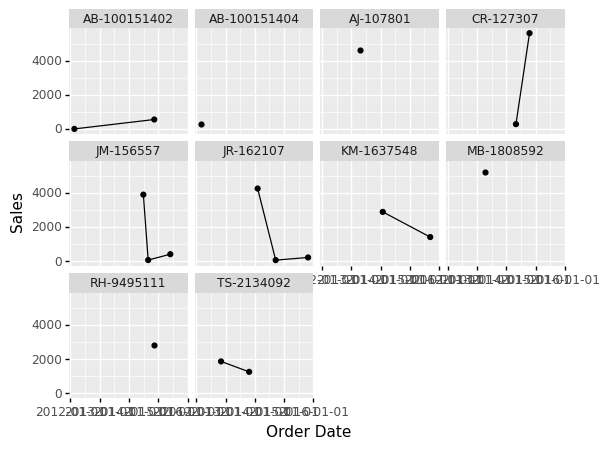

<ggplot: (108818521561)>

In [46]:
# Frequency plot of the ten unique customers, with the price and date of each transaction.
pn.ggplot(pn.aes('Order Date', 'Sales', group = 'Customer ID'), data = GD_SUBSET) + pn.geom_line() +pn.geom_point() +pn.facet_wrap('Customer ID') +pn.scale_x_date(date_breaks = '1 year', date_lables = '%Y')

## Recency-Frequency-Monetary (RFM) analysis:

For Recency, calculating the number of days between present date and date of last purchase for each customer.

For Frequency, calculating the number of orders for each customer.

For Monetary, calculating the sum of purchase price for each customer.

In [47]:
transaction_data = super_store_data[['Customer ID','Order ID','Order Date','Sales', 'Quantity','Discount']].copy()
transaction_data

,Customer ID,Order ID,Order Date,Sales,Quantity,Discount
0,AB-100151402,CA-2014-AB10015140-41954,2014-11-11,221.980,2,0.0
1,JR-162107,IN-2014-JR162107-41675,2014-02-05,3709.395,9,0.1
2,CR-127307,IN-2014-CR127307-41929,2014-10-17,5175.171,9,0.1
3,KM-1637548,ES-2014-KM1637548-41667,2014-01-28,2892.510,5,0.1
4,RH-9495111,SG-2014-RH9495111-41948,2014-11-05,2832.960,8,0.0
...,...,...,...,...,...,...
51285,KE-1642066,IN-2015-KE1642066-42174,2015-06-19,65.100,5,0.0
51286,ZD-219251408,US-2014-ZD21925140-41765,2014-05-06,16.720,5,0.2
51287,ZD-219251404,CA-2012-ZD21925140-41147,2012-08-26,8.560,2,0.0
51288,RB-1979518,MX-2013-RB1979518-41322,2013-02-17,13.440,2,0.0


In [48]:
max_date_considered = transaction_data['Order Date'].max().date()
print("Date considered for calculating the recency: ", max_date_considered.strftime("%m-%d-%Y"))

Date considered for calculating the recency:  12-31-2015


In [49]:
# Count of days since their last purchase until current date
rfm = pd.DataFrame((max_date_considered - transaction_data.groupby("Customer ID")["Order Date"].max().apply(lambda x: x.date())).dt.days)
rfm

,Order Date
Customer ID,
AA-10315102,358
AA-10315120,959
AA-10315139,149
AA-103151402,184
AA-103151404,818
...,...
ZD-2192548,750
ZD-2192564,1409
ZD-219257,1198


In [50]:
rfm.columns = ["Recency"]
rfm.head()

,Recency
Customer ID,
AA-10315102,358
AA-10315120,959
AA-10315139,149
AA-103151402,184
AA-103151404,818


In [51]:
# Count of days between their last purchase and first purchase
transaction_data.groupby("Customer ID")["Order Date"].max().apply(lambda x: x.date()) - transaction_data.groupby("Customer ID")["Order Date"].min().apply(lambda x: x.date())

Customer ID
AA-10315102    918 days
AA-10315120      0 days
AA-10315139    319 days
AA-103151402   483 days
AA-103151404   553 days
                 ...   
ZD-2192548     385 days
ZD-2192564       0 days
ZD-219257        0 days
ZD-2192582     569 days
ZD-2192596       0 days
Name: Order Date, Length: 17415, dtype: timedelta64[ns]

In [52]:
# Orders per customer
frequency_orders = transaction_data.groupby("Customer ID")["Order ID"].count()
frequency_orders

Customer ID
AA-10315102      6
AA-10315120      1
AA-10315139     13
AA-103151402     6
AA-103151404     3
                ..
ZD-2192548       4
ZD-2192564       4
ZD-219257        1
ZD-2192582       2
ZD-2192596       2
Name: Order ID, Length: 17415, dtype: int64

In [53]:
rfm = rfm.merge(frequency_orders.reset_index(), left_on = "Customer ID", right_on= "Customer ID")
rfm.head()

,Customer ID,Recency,Order ID
0,AA-10315102,358,6
1,AA-10315120,959,1
2,AA-10315139,149,13
3,AA-103151402,184,6
4,AA-103151404,818,3


In [54]:
rfm.columns = ['Customer ID', 'Recency', 'Frequency']
rfm.head()

,Customer ID,Recency,Frequency
0,AA-10315102,358,6
1,AA-10315120,959,1
2,AA-10315139,149,13
3,AA-103151402,184,6
4,AA-103151404,818,3


In [55]:
# Sales per customer
sales_per_customer = transaction_data.groupby("Customer ID")["Sales"].sum()
sales_per_customer.reset_index()

,Customer ID,Sales
0,AA-10315102,544.6560
1,AA-10315120,2713.4100
2,AA-10315139,2955.7980
3,AA-103151402,4780.5520
4,AA-103151404,753.5080
...,...,...
17410,ZD-2192548,1302.1680
17411,ZD-2192564,1225.3920
17412,ZD-219257,59.9400
17413,ZD-2192582,678.1014


In [56]:
rfm = rfm.merge(sales_per_customer.reset_index(),left_on = "Customer ID", right_on="Customer ID")
rfm.head()

,Customer ID,Recency,Frequency,Sales
0,AA-10315102,358,6,544.656
1,AA-10315120,959,1,2713.410
2,AA-10315139,149,13,2955.798
3,AA-103151402,184,6,4780.552
4,AA-103151404,818,3,753.508


In [57]:
# Renaming the column names

rfm = rfm.set_index("Customer ID") #Setting customer ID as the index for rfm dataframe
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315102,358,6,544.656
AA-10315120,959,1,2713.410
AA-10315139,149,13,2955.798
AA-103151402,184,6,4780.552
AA-103151404,818,3,753.508


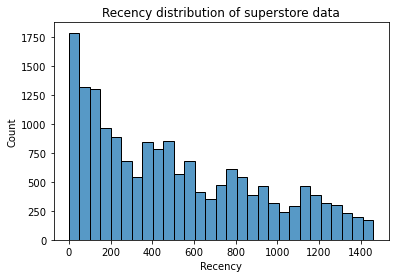

In [58]:
sns.histplot(rfm["Recency"])
plt.title("Recency distribution of superstore data")
plt.show()

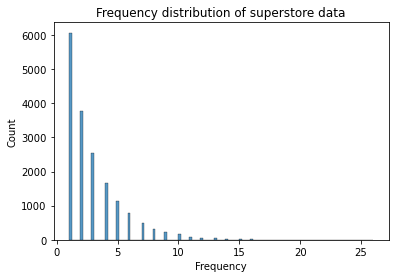

In [59]:
sns.histplot(rfm["Frequency"])
plt.title("Frequency distribution of superstore data")
plt.show()

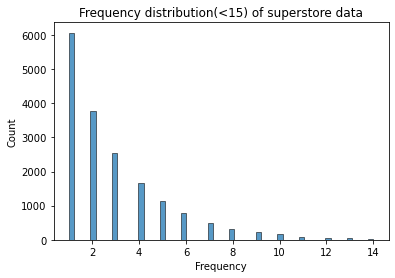

In [60]:
sns.histplot(rfm[rfm["Frequency"]<15]["Frequency"])
plt.title("Frequency distribution(<15) of superstore data")
plt.show()

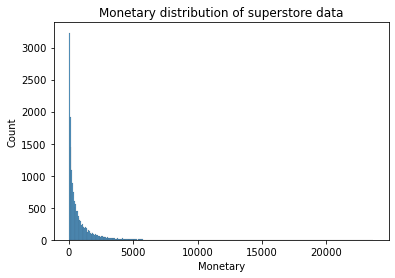

In [61]:
sns.histplot(rfm["Monetary"])
plt.title("Monetary distribution of superstore data")
plt.show()

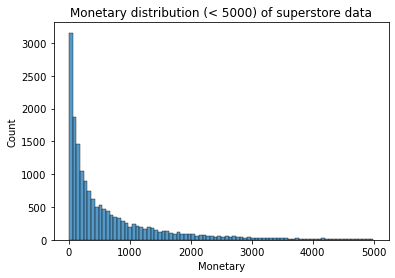

In [62]:
sns.histplot(rfm[rfm["Monetary"]<5000]["Monetary"])
plt.title("Monetary distribution (< 5000) of superstore data")
plt.show()

### Computing Quantile of RFM values
Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [63]:
rfm["Recency_quatile"] = pd.qcut(rfm["Recency"].rank(method="first"),4,['1','2','3','4']) 
# Using rank method to handle bins with duplicate edges
rfm["Frequency_quatile"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, ['4','3','2','1'])
rfm["Monetary_quantile"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, ['4','3','2','1'])
rfm.head()

,Recency,Frequency,Monetary,Recency_quatile,Frequency_quatile,Monetary_quantile
Customer ID,,,,,,
AA-10315102,358,6,544.656,2,1,2
AA-10315120,959,1,2713.410,4,4,1
AA-10315139,149,13,2955.798,2,1,1
AA-103151402,184,6,4780.552,2,1,1
AA-103151404,818,3,753.508,4,2,2


RFM Result Calculation:

Combining all three quartiles(r_quartile,f_quartile,m_quartile) to a single column, to segment the customers

In [64]:
rfm["RFM score"] = rfm[['Recency_quatile', 'Frequency_quatile', 'Monetary_quantile']].\
                    apply(lambda x: str(x[0])+str(x[1])+str(x[2]),axis=1)

In [65]:
rfm.head()

,Recency,Frequency,Monetary,Recency_quatile,Frequency_quatile,Monetary_quantile,RFM score
Customer ID,,,,,,,
AA-10315102,358,6,544.656,2,1,2,212
AA-10315120,959,1,2713.410,4,4,1,441
AA-10315139,149,13,2955.798,2,1,1,211
AA-103151402,184,6,4780.552,2,1,1,211
AA-103151404,818,3,753.508,4,2,2,422


In [66]:
# Identifing the top customers

rfm[rfm["RFM score"] == '111'].sort_values("Monetary",ascending=False)

,Recency,Frequency,Monetary,Recency_quatile,Frequency_quatile,Monetary_quantile,RFM score
Customer ID,,,,,,,
SM-203201408,79,8,23669.196,1,1,1,111
TA-213851406,69,5,13723.498,1,1,1,111
DP-131057,98,15,11864.139,1,1,1,111
FH-1436582,42,13,10880.180,1,1,1,111
VG-2180558,96,7,10058.040,1,1,1,111
...,...,...,...,...,...,...,...
TH-211151406,58,6,915.584,1,1,1,111
KA-165251406,36,6,914.578,1,1,1,111
GM-1468054,127,5,914.052,1,1,1,111


The top customer based on RFM analysis is 'SM-203201408'

### Using unsupervised learning - clustering based on each of RFM values


In [67]:
rfm_clustering = rfm[['Recency','Frequency', 'Monetary']].copy()
rfm_clustering.head()

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315102,358,6,544.656
AA-10315120,959,1,2713.410
AA-10315139,149,13,2955.798
AA-103151402,184,6,4780.552
AA-103151404,818,3,753.508


In [68]:
rfm_clustering = rfm_clustering.reset_index()
rfm_clustering

,Customer ID,Recency,Frequency,Monetary
0,AA-10315102,358,6,544.6560
1,AA-10315120,959,1,2713.4100
2,AA-10315139,149,13,2955.7980
3,AA-103151402,184,6,4780.5520
4,AA-103151404,818,3,753.5080
...,...,...,...,...
17410,ZD-2192548,750,4,1302.1680
17411,ZD-2192564,1409,4,1225.3920
17412,ZD-219257,1198,1,59.9400
17413,ZD-2192582,196,2,678.1014


In order to perform k means clustering, scaling the data to avoid influence of scale during cluster identification

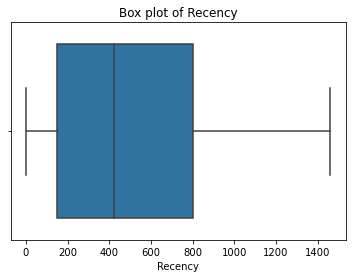

In [69]:
sns.boxplot(x = rfm_clustering["Recency"])
plt.title("Box plot of Recency")
plt.show()

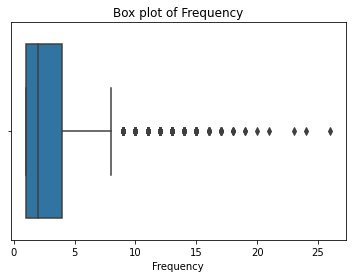

In [70]:
sns.boxplot(x = rfm_clustering["Frequency"])
plt.title("Box plot of Frequency")
plt.show()

In [71]:
rfm_clustering[rfm_clustering["Frequency"]>7].shape

(971, 4)

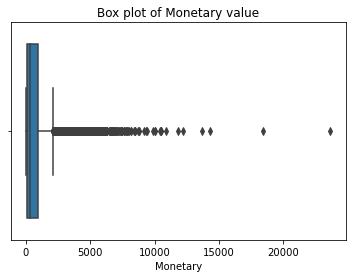

In [72]:
sns.boxplot(x = rfm_clustering["Monetary"])
plt.title("Box plot of Monetary value")
plt.show()

In [73]:
rfm_clustering[rfm_clustering["Monetary"]>2500].shape

(1088, 4)

As the box plot indicates, outliers in Frequency and Monetary values, of all the available scaling techniques, using the RobustScalar as the scaling happens based on percentiles and is not influenced by the few marginal outleirs in the data.

In [74]:
from sklearn.preprocessing import RobustScaler

In [75]:
rscaler = RobustScaler()

In [76]:
rfm_clustering["Recency_norm"] = rscaler.fit_transform(rfm_clustering[["Recency"]])

In [77]:
rfm_clustering["Frequency_norm"] = rscaler.fit_transform(rfm_clustering[["Frequency"]])
rfm_clustering["Monetary_norm"] = rscaler.fit_transform(rfm_clustering[["Monetary"]])

In [78]:
rfm_clustering.head()

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm
0,AA-10315102,358,6,544.656,-0.096183,1.333333,0.267231
1,AA-10315120,959,1,2713.410,0.821374,-0.333333,2.929883
2,AA-10315139,149,13,2955.798,-0.415267,3.666667,3.227471
3,AA-103151402,184,6,4780.552,-0.361832,1.333333,5.467782
4,AA-103151404,818,3,753.508,0.606107,0.333333,0.523646


In [79]:
rfm_clustering[['Recency_norm', 'Frequency_norm', 'Monetary_norm']].describe()

,Recency_norm,Frequency_norm,Monetary_norm
count,17415.000000,17415.000000,17415.000000
mean,0.131432,0.315054,0.489817
std,0.611632,0.799824,1.307231
min,-0.642748,-0.333333,-0.400779
25%,-0.416794,-0.333333,-0.280720
50%,0.000000,0.000000,0.000000
75%,0.583206,0.666667,0.719280
max,1.586260,8.000000,28.658004


In [80]:
from sklearn.cluster import KMeans

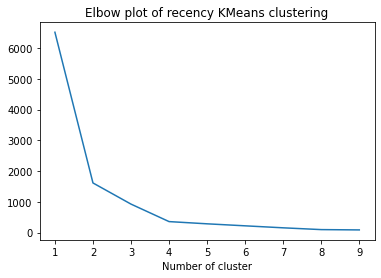

In [81]:
sse={}
recency = rfm_clustering[['Recency_norm']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Elbow plot of recency KMeans clustering")
plt.xlabel("Number of cluster")
plt.show()

In [82]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(recency[['Recency_norm']])
rfm_clustering['RecencyCluster'] = kmeans.predict(rfm_clustering[['Recency_norm']])

In [83]:
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster
0,AA-10315102,358,6,544.6560,-0.096183,1.333333,0.267231,2
1,AA-10315120,959,1,2713.4100,0.821374,-0.333333,2.929883,3
2,AA-10315139,149,13,2955.7980,-0.415267,3.666667,3.227471,1
3,AA-103151402,184,6,4780.5520,-0.361832,1.333333,5.467782,1
4,AA-103151404,818,3,753.5080,0.606107,0.333333,0.523646,3
...,...,...,...,...,...,...,...,...
17410,ZD-2192548,750,4,1302.1680,0.502290,0.666667,1.197254,3
17411,ZD-2192564,1409,4,1225.3920,1.508397,0.666667,1.102993,0
17412,ZD-219257,1198,1,59.9400,1.186260,-0.333333,-0.327871,0
17413,ZD-2192582,196,2,678.1014,-0.343511,0.000000,0.431066,1


In [84]:
def order_cluster(cluster_field, target_field,df,ascending):
    """
    function to assign the label values based on a particular sorting order defined as a parameter
    
    cluster_field: Field/column name storing the cluster
    target_field: Field storing the respective rfm actual values
    df: dataframe
    ascending: True/False
    
    """
    
    df_new = df.groupby(cluster_field)[target_field].mean().reset_index()
    df_new = df_new.sort_values(by=target_field,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field,'index']], on=cluster_field)
    df_final = df_final.drop([cluster_field],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field})
    return df_final

In [85]:
rfm_clustering = order_cluster("RecencyCluster", "Recency", rfm_clustering,False)
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster
0,AA-10315102,358,6,544.656,-0.096183,1.333333,0.267231,2
1,AA-1031548,511,1,68.148,0.137405,-0.333333,-0.317794,2
2,AA-10375101,551,4,243.486,0.198473,0.666667,-0.102526,2
3,AA-103751404,538,4,72.808,0.178626,0.666667,-0.312073,2
4,AA-103751408,411,4,598.480,-0.015267,0.666667,0.333312,2
...,...,...,...,...,...,...,...,...
17410,YS-2188044,1167,3,657.360,1.138931,0.333333,0.405601,0
17411,ZD-11925134,1028,1,13.560,0.926718,-0.333333,-0.384813,0
17412,ZD-1192583,1120,1,241.800,1.067176,-0.333333,-0.104596,0
17413,ZD-2192564,1409,4,1225.392,1.508397,0.666667,1.102993,0


In [86]:
rfm_clustering["RecencyCluster"].value_counts()

3    6794
2    4757
1    3354
0    2510
Name: RecencyCluster, dtype: int64

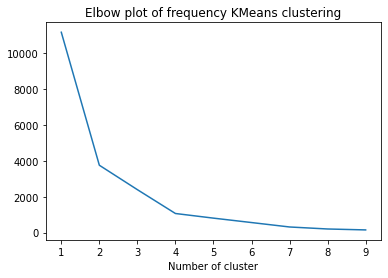

In [87]:
sse={}
frequency = rfm_clustering[['Frequency_norm']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Elbow plot of frequency KMeans clustering")
plt.xlabel("Number of cluster")
plt.show()

In [88]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_clustering[['Frequency_norm']])
rfm_clustering['FrequencyCluster'] = kmeans.predict(rfm_clustering[['Frequency_norm']])

In [89]:
rfm_clustering = order_cluster("FrequencyCluster", "Frequency", rfm_clustering,True)
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster,FrequencyCluster
0,AA-10315102,358,6,544.6560,-0.096183,1.333333,0.267231,2,2
1,AA-1037564,366,6,469.6020,-0.083969,1.333333,0.175085,2,2
2,AA-1064564,355,5,439.5000,-0.100763,1.000000,0.138127,2,2
3,AB-1001545,322,5,2822.7270,-0.151145,1.000000,3.064095,2,2
4,AB-1001548,295,6,733.1760,-0.192366,1.333333,0.498683,2,2
...,...,...,...,...,...,...,...,...,...
17410,MY-1829527,1055,12,4634.3100,0.967939,3.333333,5.288236,0,3
17411,RH-9555110,1245,9,4055.6100,1.258015,2.333333,4.577747,0,3
17412,SB-2017027,1161,12,6577.6500,1.129771,3.333333,7.674140,0,3
17413,SC-200201402,1147,16,2785.3796,1.108397,4.666667,3.018242,0,3


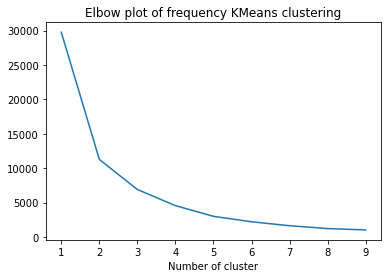

In [90]:
sse={}
monetary = rfm_clustering[['Monetary_norm']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(monetary)
    monetary["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Elbow plot of frequency KMeans clustering")
plt.xlabel("Number of cluster")
plt.show()

In [91]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_clustering[['Monetary_norm']])
rfm_clustering['MonetaryCluster'] = kmeans.predict(rfm_clustering[['Monetary']])

In [92]:
rfm_clustering = order_cluster("MonetaryCluster", "Monetary", rfm_clustering,True)
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster,FrequencyCluster,MonetaryCluster
0,AA-10315102,358,6,544.656,-0.096183,1.333333,0.267231,2,2,2
1,AA-1037564,366,6,469.602,-0.083969,1.333333,0.175085,2,2,2
2,AA-1064564,355,5,439.500,-0.100763,1.000000,0.138127,2,2,2
3,AB-1001545,322,5,2822.727,-0.151145,1.000000,3.064095,2,2,2
4,AB-1001548,295,6,733.176,-0.192366,1.333333,0.498683,2,2,2
...,...,...,...,...,...,...,...,...,...,...
17410,PF-9165134,1295,1,2.652,1.334351,-0.333333,-0.398206,0,0,1
17411,TS-1137095,1182,1,2.286,1.161832,-0.333333,-0.398655,0,0,1
17412,TS-213401402,1026,1,1.112,0.923664,-0.333333,-0.400096,0,0,1
17413,RS-197651402,303,1,0.556,-0.180153,-0.333333,-0.400779,2,0,0


In [93]:
rfm_clustering['OverallScore'] = rfm_clustering['RecencyCluster'] + rfm_clustering['FrequencyCluster'] + rfm_clustering['MonetaryCluster']

In [94]:
rfm_clustering["OverallScore"].value_counts()

5    4792
4    3592
3    2711
6    2510
2    1783
7    1575
8     442
1       9
0       1
Name: OverallScore, dtype: int64

In [95]:
rfm_clustering.groupby(["OverallScore"])[["Recency","Frequency", "Monetary"]].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,1371.000000,1.000000,0.852000
1,1171.222222,1.000000,2.455444
2,1220.493550,1.333707,312.802482
3,903.719292,1.741793,414.483190
4,571.145880,2.022272,482.052017
5,269.875000,2.308639,558.948469
6,229.625896,4.285657,1081.682107
7,144.022857,6.513016,1691.572752
8,101.599548,10.945701,2651.192590


In [96]:
rfm_clustering.groupby('OverallScore')['Customer ID'].count()

OverallScore
0       1
1       9
2    1783
3    2711
4    3592
5    4792
6    2510
7    1575
8     442
Name: Customer ID, dtype: int64

In [97]:
rfm_clustering

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore
0,AA-10315102,358,6,544.656,-0.096183,1.333333,0.267231,2,2,2,6
1,AA-1037564,366,6,469.602,-0.083969,1.333333,0.175085,2,2,2,6
2,AA-1064564,355,5,439.500,-0.100763,1.000000,0.138127,2,2,2,6
3,AB-1001545,322,5,2822.727,-0.151145,1.000000,3.064095,2,2,2,6
4,AB-1001548,295,6,733.176,-0.192366,1.333333,0.498683,2,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...
17410,PF-9165134,1295,1,2.652,1.334351,-0.333333,-0.398206,0,0,1,1
17411,TS-1137095,1182,1,2.286,1.161832,-0.333333,-0.398655,0,0,1,1
17412,TS-213401402,1026,1,1.112,0.923664,-0.333333,-0.400096,0,0,1,1
17413,RS-197651402,303,1,0.556,-0.180153,-0.333333,-0.400779,2,0,0,2


In [98]:
rfm_clustering['Segment'] = 'Lost Customer'
rfm_clustering.loc[rfm_clustering['OverallScore']>2,'Segment'] = 'Low-Value' 
rfm_clustering.loc[rfm_clustering['OverallScore']>3,'Segment'] = 'Mid-Value'
rfm_clustering.loc[rfm_clustering['OverallScore']>5,'Segment'] = 'High-Value'
rfm_clustering.loc[rfm_clustering['OverallScore']>7,'Segment'] = 'Top Customer'

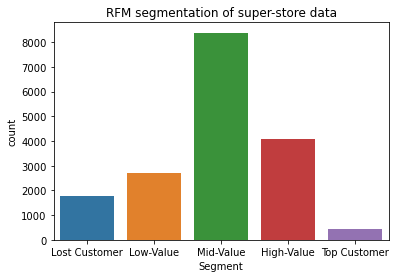

In [99]:
sns.countplot(x=rfm_clustering["Segment"],order= ['Lost Customer','Low-Value' ,'Mid-Value','High-Value','Top Customer'])
plt.title("RFM segmentation of super-store data")
plt.show()

Here, Top customers are the ones with low recency, high frequency and high monetary values; whereas lost customers are the ones who have high recency, low frequency and low monetary value

In [100]:
rfm_clustering['Segment'].value_counts()

Mid-Value        8384
High-Value       4085
Low-Value        2711
Lost Customer    1793
Top Customer      442
Name: Segment, dtype: int64

In [101]:
rfm_clustering[rfm_clustering["Segment"]=='Top Customer']

,Customer ID,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment
16901,AA-10315139,149,13,2955.7980,-0.415267,3.666667,3.227471,3,3,2,8,Top Customer
16902,AA-1064559,28,12,1873.2195,-0.600000,3.333333,1.898353,3,3,2,8,Top Customer
16903,AA-64595,60,11,555.0840,-0.551145,3.000000,0.280034,3,3,2,8,Top Customer
16904,AB-101051402,149,11,12181.5940,-0.415267,3.000000,14.554290,3,3,2,8,Top Customer
16905,AB-101057,216,10,2960.5770,-0.312977,2.666667,3.233338,3,3,2,8,Top Customer
...,...,...,...,...,...,...,...,...,...,...,...,...
17338,XP-218651404,82,12,660.1900,-0.517557,3.333333,0.409076,3,3,2,8,Top Customer
17339,YC-2189545,43,18,4160.7435,-0.577099,5.333333,4.706823,3,3,2,8,Top Customer
17340,YS-2188031,125,9,1842.4000,-0.451908,2.333333,1.860515,3,3,2,8,Top Customer
17341,ZC-219101402,194,11,3869.8060,-0.346565,3.000000,4.349629,3,3,2,8,Top Customer


In [102]:
rfm_clustering[["Customer ID", 'Monetary', 'Frequency','Recency', 'RecencyCluster', 'FrequencyCluster',
       'MonetaryCluster', 'OverallScore', 'Segment']].to_csv("RFM_segmentation.csv")